In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# This data has been obtained from https://www.health.ny.gov/statistics/cancer/registry/tract/index.htm and preprocessed by DBN.  
# It includes observed and expected (age- and population-adjusted) counts of the six most common cancer types for each
# census tract in NYC.  Some census tracts' counts have been merged by NYS, which is handled in the code below.

# Suggested Citation:
# New York State Cancer Registry. Cancer Incidence and Mortality in New York State, 1976-2018. http://www.health.ny.gov/statistics/cancer/registry/. Accessed 7/13/2021.

data = pd.read_csv("NYC Cancer Rates 2013-2017.csv")
print(data.head())

         geoid  Colorectal_observed  Colorectal_expected  Lung_observed  \
0  36005000100                    5                  9.5              9   
1  36005000200                    7                  8.6              7   
2  36005000400                   10                  9.5             11   
3  36005001600                   11                 12.9             17   
4  36005001900                    4                  2.5              5   

   Lung_expected  Breast_observed  Breast_expected  Prostate_observed  \
0            6.1                2              4.6                  8   
1           10.2               13             15.4                 11   
2           10.7               18             17.6                 11   
3           16.1               23             23.8                 16   
4            2.7                7              3.4                  8   

   Prostate_expected  Bladder_observed  Bladder_expected  NHL_observed  \
0               15.8                

In [4]:
# Visualization: example with random cluster assignments
random_clusters = np.random.randint(4,size=len(data.index))
res1=pd.concat([pd.Series(data.geoid),pd.Series(random_clusters,name='cluster')],axis=1)

# pairs of census tracts merged by NYS - assign each pair the same cluster
dict_to_add = {'36005002000':'36005002400', 
               '36005003500':'36005003700',
               '36005009000':'36005011000',
               '36005015300':'36005016300',
               '36005024502':'36005024900',
               '36005030000':'36005027600',
               '36005030900':'36005031900',
               '36005039300':'36005033400',
               '36005043100':'36005043500',
               '36005045600':'36005050400',
               '36047000200':'36047001800',
               '36047001500':'36047001100',
               '36047003300':'36047003700',
               '36047015200':'36047016400',
               '36047021100':'36047054300',
               '36047028502':'36047028501',
               '36047040500':'36047040700',
               '36047046202':'36047045000',
               '36047070201':'36047070202',
               '36047085000':'36047085200',
               '36047093000':'36047096000',
               '36047114202':'36047118000',
               '36047150200':'36047017500',
               '36061000900':'36061031900',
               '36061008601':'36061008602',
               '36061010100':'36061010900',
               '36061010400':'36061010200',
               '36061016200':'36061024000',
               '36061016800':'36061014300',              
               '36061020101':'36061019701',
               '36061020500':'36061020300',
               '36061021303':'36061021703',
               '36061027700':'36061031100',
               '36061029500':'36061029700',
               '36081000100':'36081019900',
               '36081003900':'36081003700',
               '36081004401':'36081005000',
               '36081018102':'36081017100',
               '36081020500':'36081022900',
               '36081031700':'36081033100',
               '36081043200':'36081042600',
               '36081052100':'36081060701',
               '36081053100':'36081021900',
               '36081055500':'36081055900',
               '36081056700':'36081056100',
               '36081061301':'36081061302',
               '36081063900':'36081064102',
               '36081077905':'36081038302',
               '36081087100':'36081038301',
               '36081088400':'36081071600',
               '36081092200':'36081091800',
               '36081099703':'36081099900',
               '36081129103':'36081128300',
               '36081137700':'36081138502',               
               '36085007400':'36085001800',
               '36085029102':'36085022800'}

# run this code after cluster assignment and before visualization
res2 = pd.DataFrame()
res2['geoid']=[]
res2['cluster']=[]
for from_geo in dict_to_add:
    to_geo = dict_to_add[from_geo]
    theclust = res1[res1['geoid']==int(from_geo)].iloc[0,1]
    res2=res2.append({'geoid':to_geo,'cluster':theclust},ignore_index=True)
res=pd.concat([res1,res2],ignore_index=True).astype({'cluster':int})

Reference for visualization function: 

https://arxiv.org/pdf/1611.06660.pdf


In [5]:
def visualization(result):
    import shapefile
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    #   -- input --
    nyc_geoid=list(result.geoid.unique())
    sf = shapefile.Reader("nyct2010_21b/nyct2010.shp")
    recs    = sf.records()
    test=pd.DataFrame(recs)
    test.loc[:,'county']=0
    test.loc[test.iloc[:,2]=="Staten Island","county"]="085"
    test.loc[test.iloc[:,2]=="Manhattan","county"]="061"
    test.loc[test.iloc[:,2]=="Brooklyn","county"]="047"
    test.loc[test.iloc[:,2]=="Bronx","county"]="005"
    test.loc[test.iloc[:,2]=="Queens","county"]="081"
    test.loc[:,"geoid"]=0
    test.loc[:,"geoid"]="36"+test.county+test.iloc[:,3].apply(str)

    shapes  = sf.shapes()
    Nshp    = len(shapes)
    cns     = []
    for nshp in range(Nshp):
        cns.append(recs[nshp][1])
    cns = np.array(cns)

    cmap = plt.cm.Spectral(np.linspace(0,1,max(result.iloc[:,-1])+1))

    fig=plt.figure(figsize = (10,10)) 
    fig.add_subplot(111)
    ax = fig.gca() 
    for nshp in range(Nshp):
        if int(test.iloc[nshp,-1]) in nyc_geoid:
            k=result[result.geoid==int(test.iloc[nshp,-1])].iloc[0,-1]
            c=cmap[k][0:3]  
            ptchs   = []
            pts     = np.array(shapes[nshp].points)
            prt     = shapes[nshp].parts
            par     = list(prt) + [pts.shape[0]]
            for pij in range(len(prt)):
                ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
            ax.add_collection(PatchCollection(ptchs,facecolor=c,edgecolor='k', linewidths=.5))
        ax.axis('scaled')

    import matplotlib.patches as mpatches
    clum_num=len(result.iloc[:,-1].unique())

    handles=[]
    for t in range(clum_num):
        locals()["patch_{}".format(t)] = mpatches.Patch(color=cmap[t][0:3] , label='Cluster'+str(t+1))
        handles.append(locals()["patch_{}".format(t)])
    #plt.axis('off')
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title('NYC tract data')
    plt.legend(handles=handles,loc='upper left',prop={'size':8})
    plt.show()

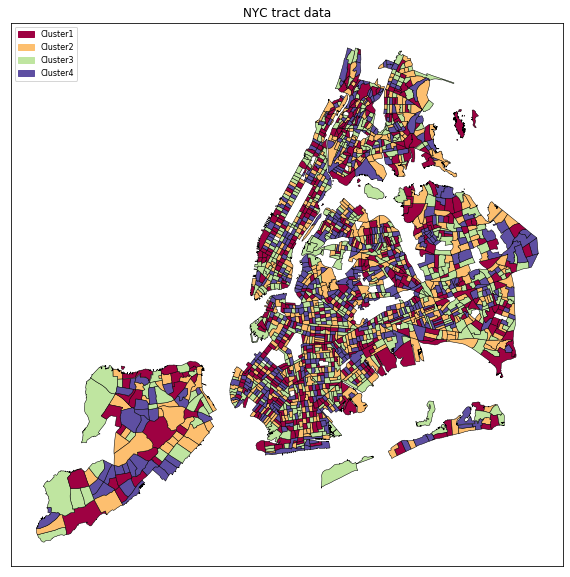

In [7]:
visualization(result=res)